# Using the data from Scopus


-  Manual export of a bibtex file.


1. Just get the DOI list
2. Query Crossref for the formatted reference resolution: obtain DOI

In [84]:
import bibtexparser as bib

In [85]:
import crossrefexp as exp

In [86]:
datafile = 'data/citing_Nye1953_journals_short.bib'

In [68]:
with open(datafile) as bibtex_file:
    bibdata = bib.load(bibtex_file)

doi_list = [  entry['doi'] for entry in bibdata.entries ]

print(len(doi_list))

7


In [69]:
doi_list

['10.1016/j.matdes.2018.04.040',
 '10.1016/j.scriptamat.2018.05.020',
 '10.1016/j.actamat.2018.05.022',
 '10.1016/j.ijfatigue.2018.03.030',
 '10.1016/j.ijplas.2018.01.014',
 '10.1016/j.msea.2018.05.028',
 '10.1016/j.commatsci.2018.02.058']

In [87]:
store = exp.MetaDataStore('data/fromScopus.pickle')

default pickle location set to data/fromScopus.pickle


Requesing 7 metadata:..
Query performed in 1.082073 s. (7 doi)
7 metadata returned for 7 asked
data/fromScopus.pickle saved.
growth achieved - 7 nodes in the graph. The last generation number is 0.
growth achieved - 7 nodes in the graph. The last generation number is 0.
graphs/Fanicchia2018Zhang2018Zhu2018Zhang2018Admal2018Zhu2018Kositski2018_gen2_top1.svg  saved


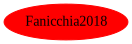

In [88]:
# Build the graph and everything:
gr = store.get_refgraphviz( doi_list, gen=2, top=1, draw_secondary_links=True )
gr

In [89]:
for doi in doi_list:
    print(store.get_info(doi))

Residual stress and adhesion of thermal spray coatings: Microscopic view by...
(2018) Materials & Design
F. Fanicchia, X. Maeder, J. Ast, A.A. Taylor, Y. Guo, M.N. Polyakov, J. Michler, D.A. Axinte
57 references - 0 given and 0 with doi
0 times cited.

Design of non-equiatomic high entropy alloys with heterogeneous lamella str...
(2018) Scripta Materialia
Cheng Zhang, Chaoyi Zhu, Tyler Harrington, Kenneth Vecchio
56 references - 0 given and 0 with doi
0 times cited.

Dislocation-type evolution in quasi-statically compressed polycrystalline n...
(2018) Acta Materialia
Chaoyi Zhu, Tyler Harrington, George T. Gray, Kenneth S. Vecchio
58 references - 0 given and 0 with doi
0 times cited.

Phase morphology, variants and crystallography of alloy microstructures in...
(2018) International Journal of Fatigue
Zhen Zhang, Fionn P.E. Dunne
62 references - 0 given and 0 with doi
1 times cited.

A unified framework for polycrystal plasticity with grain boundary evolutio...
(2018) International Jour

## Retrieving the ref using scopus data
https://www.crossref.org/labs/resolving-citations-we-dont-need-no-stinkin-parser/

In [62]:
import requests
import urllib.parse

In [63]:
metadata = bibdata.entries[2]

In [64]:
references = metadata['references'].split(';')
references = [ ref.strip() for ref in references ]
print('\n'.join(references))

Meyers, M.A., Chawla, K.K., Mechanical Behavior of Materials (2009), Cambridge University Press Cambridge
Hull, D., Bacon, D.J., Introduction to Dislocations (2011), 5 ed. Elsevier
Cai, W., Nix, W.D., Imperfections in Crystalline Solids (2016), Cambridge University Press
Hansen, N., Polycrystalline strengthening (1985) Metallurgical Transactions A, 16 (12), pp. 2167-2190
Ashby, M., The deformation of plastically non-homogeneous materials (1970) Phil. Mag., 21 (170), pp. 399-424
Gray, G.T., III, Chen, S.R., Vecchio, K.S., Influence of grain size on the constitutive response and substructure evolution of MONEL 400 (1999) Metall. Mater. Trans., 30 (5), pp. 1235-1247
Kuhlmann-Wilsdorf, D., Hansen, N., Geometrically necessary, incidental and subgrain boundaries (1991) Scripta Metall. Mater., 25 (7), pp. 1557-1562
Mughrabi, H., Wang, R., Hansen, N., Horsewell, A., Leffers, T., Lilholt, H., Deformation of polycrystals: mechanisms and microstructures (1981) Proc. 2nd Risø Int. Symp. On Metallu

In [81]:
def query_crossref_biblio(ref_text, mailadress=''):
    """ Query Crossref for the given formatted reference text."""
    
    print( 'Query for "{}..."'.format( ref_text[:60] ), end='\r' )
    minimum_score_required = 40
    
    url = "https://api.crossref.org/works"

    params = {'mailto': mailadress,
              'query.bibliographic':ref_text}

    response = requests.get(url, params=params)
    
    if not response.ok:
        print('query error: %s' % response.content)
    else:
       
        r = response.json()
        items = r['message']['items']

        sorted_match = sorted( items, key=lambda x:x['score'], reverse=True )
        best_match = sorted_match[0]
        
        print( ' '*80, end='\r' )
        print( 'Query answered in {:3f} s. Score: {}'.format( response.elapsed.total_seconds(), best_match['score'] ) )
    
    
    if best_match['score'] > minimum_score_required:
        return best_match
    else:
        return None


In [83]:
ref_text = references[11]

best_match = query_crossref_biblio( ref_text )
best_match

Query answered in 3.237090 s. Score: 46.835865                                  


{'DOI': '10.1299/jsmemag.57.421_158_1',
 'ISSN': ['2424-2675'],
 'URL': 'http://dx.doi.org/10.1299/jsmemag.57.421_158_1',
 'container-title': ['Journal of the Society of Mechanical Engineers'],
 'content-domain': {'crossmark-restriction': False, 'domain': []},
 'created': {'date-parts': [[2017, 6, 30]],
  'date-time': '2017-06-30T23:12:42Z',
  'timestamp': 1498864362000},
 'deposited': {'date-parts': [[2017, 6, 30]],
  'date-time': '2017-06-30T23:12:42Z',
  'timestamp': 1498864362000},
 'indexed': {'date-parts': [[2018, 5, 7]],
  'date-time': '2018-05-07T16:29:16Z',
  'timestamp': 1525710556896},
 'is-referenced-by-count': 0,
 'issn-type': [{'type': 'electronic', 'value': '2424-2675'}],
 'issue': '421',
 'issued': {'date-parts': [[1954]]},
 'journal-issue': {'issue': '421',
  'published-print': {'date-parts': [[1954]]}},
 'language': 'en',
 'link': [{'URL': 'https://www.jstage.jst.go.jp/article/jsmemag/57/421/57_KJ00001463065/_pdf',
   'content-type': 'unspecified',
   'content-version